In [2]:
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from nltk.corpus import wordnet as wn

plt.rcParams.update({
    'font.size': 12,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})


In [60]:
# find best values

s = """"""

s_lst = s.split('\n')
s_eng = [x for i, x in enumerate(s_lst) if i % 3 == 0]
s_chi = [x for i, x in enumerate(s_lst) if i % 3 == 1]
s_ger = [x for i, x in enumerate(s_lst) if i % 3 == 2]

print(sorted(s_eng, key=lambda x: -float(x.split()[-1]))[0])
print(sorted(s_chi, key=lambda x: -float(x.split()[-1]))[0])
print(sorted(s_ger, key=lambda x: -float(x.split()[-1]))[0])



log_4_val_0.3_10.txt:best alpha, beta = 0.01, 0.01; mrr = 0.052737353602495526


In [63]:
# get computed ranks across k folds
from itertools import product

def process_retrievals(entry):
    lst = [w.split('-') for w in entry.split(', ')]
    return ', '.join(['-'.join(w[::-1]) for w in lst])

input_csv = "combination_pred_{lang}_1_0_{t}_{alpha}_{beta}_{lbd}_{gamma}_{theta}_{num_splits}_1_{test_split}_{val_split}_{seed}.csv"
input_csv = "outputs/splits/" + input_csv

langs2 = ['eng', 'chi', 'ger']
langs2_string = ['English', 'Chinese', 'German']
model_types = [0, 1, 10]
model_types_string = ['comp-only', 'comp-analogy', 'prior-only']

seed = 0
num_splits = 5
val_split_lst = [1, 2, 3, 4, 0]

alpha_lsts = {
    0: {
        'eng': [0.01, 0.01, 0.01, 0.01, 0.01],
        'chi': [0.1, 0.01, 0.1, 0.01, 1.0],
        'ger': [0.01, 0.01, 0.1, 0.1, 0.1]
    },
    1: {
        'eng': [0.01, 0.01, 0.1, 0.01, 0.01],
        'chi': [0.1, 0.01, 0.01, 0.1, 0.1],
        'ger': [0.01, 0.01, 0.01, 0.01, 0.01]
    },
    10: {
        'eng': [1.0, 0.01, 1.0, 1.0 ,1.0],
        'chi': [100.0, 0.01, 0.01, 100.0, 0.01],
        'ger': [100.0, 100.0, 0.1, 10.0, 0.1]
    },
}
beta_lsts = {
    0: {
        'eng': [0.1, 0.1, 0.1, 0.01, 0.1],
        'chi': [0.01, 0.1, 0.1, 0.1, 0.1],
        'ger': [0.1, 0.01, 0.1, 0.1, 0.1]
    },
    1: {
        'eng': [0.1, 0.1, 0.1, 0.01, 0.1],
        'chi': [0.01, 0.01, 0.01, 0.01, 0.01],
        'ger': [0.01, 0.01, 0.01, 0.01, 0.01]
    },
    10: {
        'eng': [1.0, 1.0, 0.1, 0.01, 1.0],
        'chi': [0.1, 1.0, 0.01, 0.1, 1.0],
        'ger': [0.01, 0.1, 100.0, 100.0, 0.01]
    },
}
gamma_lsts = {
    'eng': [0.3, 0.3, 0.3, 0.2, 0.4],
    'chi': [0.2, 0.2, 0.2, 0.3, 0.2],
    'ger': [0.3, 0.3, 0.3, 0.3, 0.3]
}
theta_lsts = {
    'eng': [100.0, 100.0, 10.0, 100.0, 1.0],
    'chi': [100.0, 100.0, 100.0, 100.0, 100.0],
    'ger': [10.0, 100.0, 100.0, 10.0, 10.0]
}
lbd = 0.5

df_dict = {lang: None for lang in langs2}
fn_lst = []
for lang in langs2:
    print(lang)
    df_lst = []
    for i in range(num_splits):
        j = val_split_lst[i]
        for k, t in enumerate(model_types):
            df_cur = None
            if t == 0:
                alpha = alpha_lsts[t][lang][i]
                beta = beta_lsts[t][lang][i]
                
                fn = input_csv.format(t=t, lang=lang, alpha=alpha, beta=beta, lbd=lbd,\
                                      theta=1.0, gamma=0.0, num_splits=num_splits, \
                                      test_split=i, val_split=j, seed=seed)
                # fn_lst.append(fn)
                df_cur = pd.read_csv(fn)
            elif t == 1:
                alpha = alpha_lsts[t][lang][i]
                beta = beta_lsts[t][lang][i]
                gamma = gamma_lsts[lang][i]
                theta = theta_lsts[lang][i]
                
                fn = input_csv.format(t=t, lang=lang, alpha=alpha, beta=beta, lbd=lbd,\
                                      theta=theta, gamma=gamma, num_splits=num_splits, \
                                      test_split=i, val_split=j, seed=seed)
                # fn_lst.append(fn)
                df_cur = pd.read_csv(fn)
            elif t == 10:
                alpha = alpha_lsts[t][lang][i]
                beta = beta_lsts[t][lang][i]
                fn = input_csv.format(t=t, lang=lang, alpha=alpha, beta=beta, lbd=lbd,\
                                      theta=1.0, gamma=0.0, num_splits=num_splits, \
                                      test_split=i, val_split=j, seed=seed)
                # fn_lst.append(fn)
                df_cur = pd.read_csv(fn)
                
            df_cur['top retrievals'] = [process_retrievals(row) for row in df_cur['top retrievals'].to_list()]
            df_cur['model type'] = model_types_string[k]
            df_cur['fold num'] = i
            df_lst.append(df_cur)

    df = pd.concat(df_lst)
    df_dict[lang] = df
    print(df)

print(' '.join(fn_lst))


eng
          compound    head modifier  head family size      rank  \
0       brainstorm   storm    brain                 4   13056.0   
1        coalfield   field     coal                 9     293.0   
2        guardroom    room    guard                23     127.0   
3        flagstone   stone     flag                38    1576.0   
4         sawtooth   tooth      saw                 2  726349.0   
...            ...     ...      ...               ...       ...   
1013      eyesight   sight      eye                 1  246823.5   
1014       foxhole    hole      fox                18   45642.5   
1015      birthday     day    birth                 5  265233.5   
1016       tramway     way     tram                38   13804.0   
1017  draftsperson  person   drafts                 6  374657.5   

                                         top retrievals  model type  fold num  
0     buzz-dreaming, buzz-band, buzz-mind, buzz-drea...   comp-only         0  
1     coal-line, coal-west, coa

In [64]:
# get computed ranks across k folds (likelihood only)

input_csv_li = "combination_pred_{lang}_1_0_{t}_{alpha}_{beta}_{lbd}_{gamma}_{theta}_{num_splits}_1_{test_split}_{val_split}_{seed}.csv"
input_csv_li = "outputs/splits_no_prior/" + input_csv_li

gamma_lsts_li = {
    'eng': [0.3, 0.3, 0.3, 0.3, 0.3],
    'chi': [0.4, 0.3, 0.3, 0.2, 0.3],
    'ger': [0.3, 0.3, 0.3, 0.3, 0.2]
}
theta_lsts_li = {
    'eng': [1.0, 10.0, 1.0, 10.0, 10.0],
    'chi': [100.0, 10.0, 100.0, 100.0, 100.0],
    'ger': [1.0, 1.0, 1.0, 1.0, 1.0]
}

df_dict_li = {lang: None for lang in langs2}
fn_lst = []
for lang in langs2:
    print(lang)
    df_lst = []
    for i in range(num_splits):
        j = val_split_lst[i]
        for k, t in enumerate(model_types[0:2]):
            if t == 0:
                fn = input_csv_li.format(t=t, lang=lang, alpha=1.0, beta=1.0, lbd=lbd,\
                                         theta=1.0, gamma=0.0, num_splits=num_splits, \
                                         test_split=i, val_split=j, seed=seed)
                df_cur = pd.read_csv(fn)
                # fn_lst.append(fn)
                
            if t == 1:
                gamma = gamma_lsts_li[lang][i]
                theta = theta_lsts_li[lang][i]
                
                fn = input_csv_li.format(t=t, lang=lang, alpha=1.0, beta=1.0, lbd=lbd,\
                                         theta=theta, gamma=gamma, num_splits=num_splits, \
                                         test_split=i, val_split=j, seed=seed)
                df_cur = pd.read_csv(fn)
                # fn_lst.append(fn)
                
            df_cur['top retrievals'] = [process_retrievals(row) for row in df_cur['top retrievals'].to_list()]
            df_cur['model type'] = model_types_string[k]
            df_cur['fold num'] = i
            df_lst.append(df_cur)

    df = pd.concat(df_lst)
    df_dict_li[lang] = df
    print(df)

print(' '.join(fn_lst))


eng
          compound    head modifier  head family size       rank  \
0       brainstorm   storm    brain                 4   188831.5   
1        coalfield   field     coal                 9     2829.5   
2        guardroom    room    guard                23     2923.5   
3        flagstone   stone     flag                38    17004.5   
4         sawtooth   tooth      saw                 2  2826448.5   
...            ...     ...      ...               ...        ...   
1013      eyesight   sight      eye                 1       35.0   
1014       foxhole    hole      fox                18   100728.0   
1015      birthday     day    birth                 5      706.0   
1016       tramway     way     tram                38       12.0   
1017  draftsperson  person   drafts                 6     1833.0   

                                         top retrievals    model type  \
0     dreaming-buzz, buzz-dreaming, buzz-thinking, t...     comp-only   
1     coal-coal, basin-coal, coal

2.679591228358114e-07 0.0005007852588100177
1.6004832178931462e-07 5.0014309251986045e-05
2.2221439533740866e-08 0.00012931067387438413


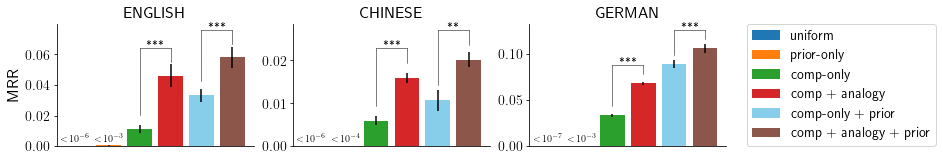

In [85]:
# make MRR plot
def compute_mrr(idxes):
    idxes = np.array(idxes)
    return np.mean(1 / (idxes + 1))

def uniform_mrr_mean(n):
    lst = np.arange(1, n+1)
    return np.mean(1 / lst)

def uniform_mrr_var(n):
    lst = np.arange(1, n+1)
    return np.mean(1 / lst**2) - uniform_mrr_mean(n)**2

def compute_mrr_over_folds(df_t, num_splits):
    mrr_lst = []
    for k in range(num_splits):
        ranks_k = df_t[df_t['fold num'] == k]['rank'].to_numpy()
        mrr_k = compute_mrr(ranks_k)
        mrr_lst.append(mrr_k)
    return mrr_lst

def plot_sl(ax, xs, ys, p, offset):
    y = np.max(ys) + 2*offset
    ax.plot([xs[0], xs[0]], [ys[0]+offset, y], color='k', linewidth=0.5)
    ax.plot([xs[1], xs[1]], [ys[1]+offset, y], color='k', linewidth=0.5)
    ax.plot(xs, [y, y], color='k', linewidth=0.5)
    if p < 0.001:
        ax.text(s="***", x=np.mean(xs), y=y, va='bottom', ha='center')
    elif p < 0.01:
        ax.text(s="**", x=np.mean(xs), y=y, va='bottom', ha='center')
    elif p < 0.05:
        ax.text(s="*", x=np.mean(xs), y=y, va='bottom', ha='center')
    else:
        ax.text(s="n.s.", x=np.mean(xs), y=y, va='bottom', ha='center')
    return ax

fig, axes = plt.subplots(1, len(langs2), sharex=False, sharey=False, figsize=(1.2+3.6*len(langs2),2.25))
lexicon_sizes = [2732, 3535, 9487]
offsets = [0.009, 0.0035, 0.01]

colors = sns.color_palette("tab10").copy()
colors[4] = 'skyblue'
text_nums = [['$<\\! 10^{-6}$', '$<\\! 10^{-6}$', '$<\\! 10^{-7}$'], 
             ['$<\\! 10^{-3}$', '$<\\! 10^{-4}$', '$<\\! 10^{-3}$']]
text_nums2 = [['$< \\frac{1}{10^5}$', '$< \\frac{1}{10^5}$', '$< \\frac{1}{10^6}$'], 
              ['$< \\frac{1}{10^3}$', '$< \\frac{1}{10^4}$', '$< \\frac{1}{10^3}$']]
for i, lang in enumerate(langs2):
    ax = axes[i]
    df = {
        'mrr': [],
        'std': [],
        'model type': [],
    }
    df_lang = df_dict[lang]
    df_lang_no_prior = df_dict_li[lang]

    # uniform
    # df['mrr'].append(uniform_mrr_mean(lexicon_sizes[i]**2))
    # df['std'].append(uniform_mrr_var(lexicon_sizes[i]**2)**0.5)
    df['mrr'].append(2/(lexicon_sizes[i]**2+1))
    df['std'].append(0)
    df['model type'].append('uniform')

    # prior only
    mrr_lst = []
    p_type = model_types_string[-1]
    mrr_lst = compute_mrr_over_folds(df_lang[df_lang['model type'] == p_type], num_splits)
    df['mrr'].append(np.mean(mrr_lst))
    df['std'].append(np.std(mrr_lst))
    df['model type'].append(p_type)
    print(df['mrr'][-2], df['mrr'][-1])

    # likelihood only
    mrr_lst_lst = []
    for j, t in enumerate(model_types_string[0:2]):
        df_t = df_lang_no_prior[df_lang_no_prior['model type'] == t]
        mrr_lst = compute_mrr_over_folds(df_t, num_splits)
        df['mrr'].append(np.mean(mrr_lst))
        df['std'].append(np.std(mrr_lst))
        df['model type'].append(['comp-only', 'comp + analogy'][j])
        
        mrr_lst_lst.append(mrr_lst)
        
    t_stat, p_val = stats.ttest_rel(mrr_lst_lst[1], mrr_lst_lst[0])
    # print(t_stat, p_val)
    ax = plot_sl(ax, [2, 3], [np.mean(lst) for lst in mrr_lst_lst[0:2]], p_val, offsets[i])
        
    # comp-only and full
    mrr_lst_lst = []
    for j, t in enumerate(model_types_string[0:2]):
        df_t = df_lang[df_lang['model type'] == t]
        mrr_lst = compute_mrr_over_folds(df_t, num_splits)
        df['mrr'].append(np.mean(mrr_lst))
        df['std'].append(np.std(mrr_lst))
        t = ['comp-only', 'comp + analogy'][j]
        df['model type'].append(f'{t} + prior')
        
        mrr_lst_lst.append(mrr_lst)
    
    t_stat, p_val = stats.ttest_rel(mrr_lst_lst[1], mrr_lst_lst[0])
    # print(t_stat, p_val)
    ax = plot_sl(ax, [4, 5], [np.mean(lst) for lst in mrr_lst_lst[0:2]], p_val, offsets[i])
    
    for j in np.arange(len(df['mrr'])):
        ax.bar(j, df['mrr'][j], yerr=df['std'][j], label=df['model type'][j], color=colors[j],)
    ax.text(x= 0.09, y= 0.05, s=text_nums[0][i], va='center', ha='center', transform=ax.transAxes, fontsize=10)
    ax.text(x= 0.265, y= 0.05, s=text_nums[1][i], va='center', ha='center', transform=ax.transAxes, fontsize=10)

    ax.set_title(langs2_string[i].upper(), fontsize=16)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    if i == 0:
        ax.set_ylabel('MRR', fontsize=16)
    else:
        ax.set_ylabel('', fontsize=16)
        
    if i == len(langs2) - 1:
        ax.legend(loc="right", bbox_to_anchor=(2.1,0.5), prop={'size': 14}, title_fontsize=16)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(
       which='both',
       top=False,
       right=False,
       labeltop=False,
       labelright=False,
    )
    ax.get_xaxis().set_ticks([])
    # ax.tick_params(axis='x', labelrotation=90)
    
fig.savefig(f'mrr_main.pdf', format='pdf', bbox_inches='tight')
plt.show()



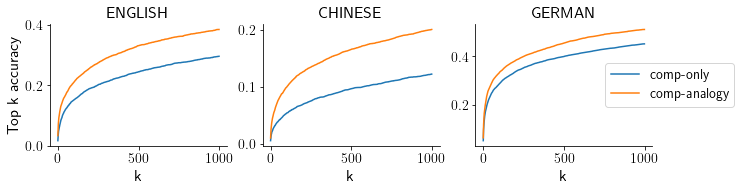

In [66]:
# make top k accuracy plot
def get_top_k(ranks, max_k):
    ret = []
    rank_count = Counter(ranks)
    n_items = sum(rank_count)
    
    partial_sum = 0
    for k in range(max_k):
        partial_sum += rank_count[k]
        ret.append(partial_sum)
        if partial_sum == n_items:
            return ret + [partial_sum for _ in range(k+1, max_k)]                
    return ret


fig, axes = plt.subplots(1, len(langs2), sharex=False, sharey=False, figsize=(3.6*len(langs2),2.25))
for i, lang in enumerate(langs2):
    df = df_dict[lang]
    df1 = df[df['model type'] == model_types_string[0]]
    df2 = df[df['model type'] == model_types_string[1]]
    ax = axes[i] if len(langs2) > 1 else axes
    
    max_k = 1000 # lexicon_sizes[i] ** 2
    x = np.arange(0, max_k)
    y1 = (np.array(get_top_k(df1['rank'], max_k)) + 1) / len(df1)
    y2 = (np.array(get_top_k(df2['rank'], max_k)) + 1) / len(df2)
    ax.plot(x, y1, label=model_types_string[0])
    ax.plot(x, y2, label=model_types_string[1])
    if i == len(langs2) - 1:
        ax.legend(loc="right", bbox_to_anchor=(1.5,0.5), prop={'size': 14})
        
    ax.set_title(langs2_string[i].upper(), fontsize=16)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    if i == 0:
        ax.set_ylabel('Top k accuracy', fontsize=16)
    ax.set_xlabel('k', fontsize=16)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(
       which='both',
       top=False,
       right=False,
       labeltop=False,
       labelright=False,
    )

fig.savefig(f'recall_k.pdf', format='pdf', bbox_inches='tight')
plt.show()




English
model type=comp-only, pearson=-0.276, p-val=0.000, n=5090
model type=comp-analogy, pearson=-0.491, p-val=0.000, n=5090
Chinese
model type=comp-only, pearson=-0.058, p-val=0.000, n=10000
model type=comp-analogy, pearson=-0.421, p-val=0.000, n=10000
German
model type=comp-only, pearson=-0.240, p-val=0.000, n=10000
model type=comp-analogy, pearson=-0.424, p-val=0.000, n=10000


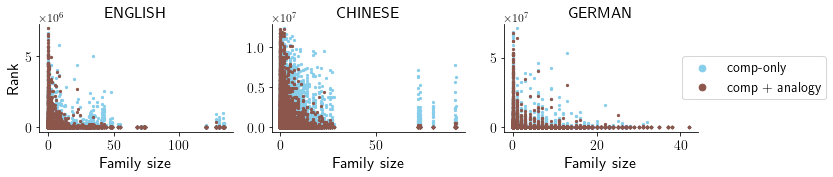

In [67]:
# compare family size and item rank
from scipy.stats import pearsonr, spearmanr

for i, lang in enumerate(langs2):
    print(langs2_string[i])
    df_lang = df_dict[lang]
    for t in model_types_string:
        if t == model_types_string[0] or t == model_types_string[1]:
            df = df_lang[df_lang['model type'] == t]
            r, p = spearmanr(df['rank'], df['head family size'])
            print(f'model type={t}, pearson={r:.3f}, p-val={p:.3f}, n={len(df)}')
            
fig, axes = plt.subplots(1, len(langs2), sharex=False, sharey=False, figsize=(1+3.6*len(langs2),2))
alpha = 1
beta = 1
gamma = 0.3
colors = ['skyblue', sns.color_palette("tab10")[5]]

for i, lang in enumerate(langs2):
    df = df_dict[lang]
    ax = axes[i] if len(langs2) > 1 else axes
    
    for j, t in enumerate(model_types_string[0:2]):
        df_t = df[df['model type'] == t]
        t = ['comp-only', 'comp + analogy'][j]
#         ax.scatter(df_t['head family size'], df_t['rank'], label=t, alpha=0.3, rasterized=False, \
#                    color=colors[j], s=50)
        ax.scatter(df_t['head family size'], df_t['rank'], label=t, alpha=1, rasterized=False, \
                   edgecolors=colors[j], facecolors=colors[j], s=5) # facecolors='none'

    if i == len(langs2) - 1:
        ax.legend(loc="right", bbox_to_anchor=(1.7,0.5), prop={'size': 14}, markerscale=3)
        
    ax.set_title(langs2_string[i].upper(), fontsize=16)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    if i == 0:
        ax.set_ylabel('Rank', fontsize=16)
    ax.set_xlabel('Family size', fontsize=16)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(
       which='both',
       top=False,
       right=False,
       labeltop=False,
       labelright=False,
    )


fig.savefig(f'ranks_family-size.pdf', format='pdf', bbox_inches='tight')
plt.show()



In [68]:
# endocentricity (English only)

def check_endocentric(compounds, head_words):
    is_literal_lst = []
    for c, h in zip(compounds, head_words):
        is_literal = False
        head_ss = [ss for ss in wn.synsets(h)]
        for ss in wn.synsets(c):
            is_literal = is_literal or any(ss2 in ss.lowest_common_hypernyms(ss2) for ss2 in head_ss)
        is_literal_lst.append(is_literal)
        
    return np.array(is_literal_lst)

def check_pos(w_list, target_pos='n'):
    is_target_lst = []
    for w in w_list:
        is_target_lst.append(target_pos in {ss.pos() for ss in wn.synsets(w)})
    return np.array(is_target_lst)

def check_is_wn(w_list):
    return np.array([len(wn.synsets(w)) > 0 for w in w_list])
        
    
df_lang = df_dict['eng']
for t in model_types_string[0:2]:
    df = df_lang[df_lang['model type'] == t]

    df = df[check_is_wn(df['compound']) & check_is_wn(df['head'])]
    df = df[check_pos(df['compound'], 'n')] # use nouns only

    endo = check_endocentric(df['compound'], df['head'])
    df_1 = df[endo]
    df_0 = df[~endo]

    ranks_1 = df_1['rank'].to_numpy()
    ranks_0 = df_0['rank'].to_numpy()
    fs_1 = np.mean(df_1['head family size'])
    fs_0 = np.mean(df_0['head family size'])
    print(f'model type={t}')
    print(f'mean endo rank = {np.mean(ranks_1):.3f}, mrr = {compute_mrr(ranks_1)} (N = {len(df_1)}, avg family size = {fs_1:.3f})')
    print(f'mean exo rank = {np.mean(ranks_0):.3f}, mrr = {compute_mrr(ranks_0)} (N = {len(df_0)}, avg family size = {fs_0:.3f})')
    print('')



model type=comp-only
mean endo rank = 110726.990, mrr = 0.04821528452805483 (N = 1962, avg family size = 14.426)
mean exo rank = 296451.011, mrr = 0.025691058130581507 (N = 2818, avg family size = 19.419)

model type=comp-analogy
mean endo rank = 93587.008, mrr = 0.06604710050361115 (N = 1962, avg family size = 14.426)
mean exo rank = 239506.139, mrr = 0.05648407509326639 (N = 2818, avg family size = 19.419)



In [79]:
# find mu_h most different from c_h
langs2 = ['eng', 'chi', 'ger']
langs2_string = ['English', 'Chinese', 'German']

input_csv = "outputs/subpatterns/head_dist_{lang}_{num_splits}_{test_split}_{val_split}_{seed}.csv"

seed = 0
num_splits = 5
val_split_lst = [1, 2, 3, 4, 0]

head_dist_dfs = {lang: None for lang in langs2}
for lang in langs2:
    df_lst = []
    for i in range(num_splits):
        j = val_split_lst[i]
        fn = input_csv.format(lang=lang, num_splits=num_splits, test_split=i, val_split=j, seed=seed)
        df = pd.read_csv(fn)
        df['split'] = i
        df_lst.append(df)

    head_dist_dfs[lang] = pd.concat(df_lst)
    print(head_dist_dfs[lang])




           head  head family size  dist(h, mu_h)  \
0          ache                 5       0.614500   
1         apple                 2       0.595551   
2           ass                 1       0.742473   
3          away                10       0.739504   
4          back                32       0.710986   
..          ...               ...            ...   
315        wort                31       0.568103   
316  worthiness                 4       0.514867   
317      wright                 3       0.711466   
318     writing                 1       0.893236   
319        yard                13       0.670526   

                                          h neighbours  \
0    ache, lachrymation, aching, biliousness, diarr...   
1    apple, macintosh, ipod, apricot, guava, orchar...   
2    ass, arse, bitch, shit, dude, fucking, bollix,...   
3    away, apart, off, out, home, aside, back, pluc...   
4    back, down, out, unwarily, then, forward, agai...   
..                         

In [69]:
# compare distances to compound
langs2 = ['eng', 'chi', 'ger']
langs2_string = ['English', 'Chinese', 'German']

input_csv = "outputs/subpatterns/target_dist_{lang}_{num_splits}_{test_split}_{val_split}_{seed}.csv"

seed = 0
num_splits = 5
val_split_lst = [1, 2, 3, 4, 0]

target_dist_dfs = {lang: None for lang in langs2}
for lang in langs2:
    df_lst = []
    for i in range(num_splits):
        j = val_split_lst[i]
        fn = input_csv.format(lang=lang, num_splits=num_splits, test_split=i, val_split=j, seed=seed)
        df = pd.read_csv(fn)
        df['split'] = i
        df_lst.append(df)

    target_dist_dfs[lang] = pd.concat(df_lst)
    print(target_dist_dfs[lang])

    

         compound    head  head family size  dist(h, c)  dist(mu_h, c)  split
0      brainstorm   storm                 4    0.788157       0.707586      0
1       coalfield   field                 9    0.858596       0.611586      0
2       guardroom    room                23    0.629649       0.571193      0
3       flagstone   stone                38    0.442351       0.383331      0
4        sawtooth   tooth                 2    0.778089       0.731873      0
..            ...     ...               ...         ...            ...    ...
833      eyesight   sight                 1    0.542881       0.835934      4
834       foxhole    hole                18    0.751621       0.683686      4
835      birthday     day                 5    0.588387       0.790396      4
836       tramway     way                38    0.852721       0.590603      4
837  draftsperson  person                 6    0.731393       0.616375      4

[4187 rows x 6 columns]
     compound head  head family size  d

0.41424758056391897 0.33838444755607267
t-stat = 29.574394238158902; pval = 9.877050497163595e-175; df = 4186
0.5038186571703683 0.3140238369799557
t-stat = 109.40003122642251; pval = 0.0; df = 8624
0.4680243506812273 0.4477340332845492
t-stat = 13.014032033828467; pval = 2.5313152009090553e-38; df = 7855


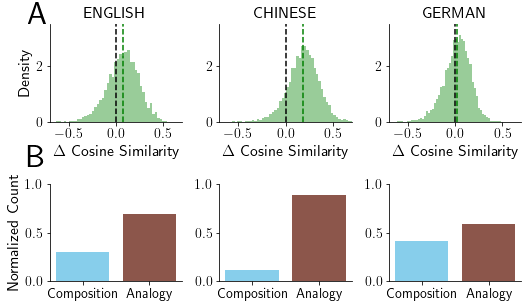

In [88]:
# make comparison plot
colors = ['skyblue', sns.color_palette("tab10")[5]]

fig, axes = plt.subplots(2, len(langs2), sharex=False, sharey=False, figsize=(2.5*len(langs2),2.25*2))
for i, lang in enumerate(langs2):
    df_lang = target_dist_dfs[lang]
    
    # distance plot
    ax = axes[0,i]
    
    c_h_sim = 1 - df_lang['dist(h, c)'].to_numpy()
    mu_h_sim = 1 - df_lang['dist(mu_h, c)'].to_numpy()
    #ax = sns.kdeplot(c_h_sim, ax=ax, color=colours[0], label='Lexical')
    #ax = sns.kdeplot(mu_h_sim, ax=ax, color=colours[1], label='Analogy')
    # ax = sns.kdeplot(mu_h_sim - c_h_sim, ax=ax, color='g')
    ax = sns.distplot(mu_h_sim - c_h_sim, ax=ax, color='g', hist=True, kde=False, norm_hist=True)
    ax.axvline(x=np.mean(mu_h_sim - c_h_sim), linestyle='dashed', color='g')
    ax.axvline(x=0, linestyle='dashed', color='k')
    
    print(np.mean(mu_h_sim), np.mean(c_h_sim))
    t_results = stats.ttest_rel(mu_h_sim, c_h_sim)
    print(f't-stat = {t_results.statistic}; pval = {t_results.pvalue}; df = {len(mu_h_sim)-1}')
    
    ax.set_title(langs2_string[i].upper(), fontsize=16)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    if i == 0:
        ax.set_ylabel('Density', fontsize=16)
    ax.set_xlabel('$\Delta$ Cosine Similarity', fontsize=16)
    
    if i == 0:
        ax.annotate('A',
                xy=(-0.1, 0.9), xytext=(-0.1, 0.9),
                xycoords=('axes fraction', 'figure fraction'),
                textcoords='offset points',
                fontsize=32, weight='bold', ha='center', va='center')
    
    #     if i == len(langs2) - 1:
    #         ax.legend(loc="right", bbox_to_anchor=(1.35,0.5), prop={'size': 14}, title_fontsize=16)
    #     else:
    #         ax.get_legend().remove()
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(
       which='both',
       top=False,
       right=False,
       labeltop=False,
       labelright=False,
    )
    ax.set_ylim([0, 3.5])
    ax.set_xlim([-0.7, 0.7])
    
    # count plot
    ax = axes[1,i]
    c_less = np.sum(df_lang['dist(h, c)'] <= df_lang['dist(mu_h, c)'])
    mu_h_less = np.sum(df_lang['dist(h, c)'] > df_lang['dist(mu_h, c)'])
    total = c_less + mu_h_less
    ax.bar([0, 1], [c_less/total, mu_h_less/total], tick_label=['Composition', 'Analogy'], color=colors)
    
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    if i == 0:
        ax.set_ylabel('Normalized Count', fontsize=16)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(
       which='both',
       top=False,
       right=False,
       labeltop=False,
       labelright=False,
    )
    ax.set_ylim([0, 1])
    
    if i == 0:
        ax.annotate('B',
                    xy=(-0.1, 0.46), xytext=(-0.1, 0.46),
                    xycoords=('axes fraction', 'figure fraction'),
                    textcoords='offset points',
                    fontsize=32, weight='bold', ha='center', va='center')

fig.tight_layout()
fig.savefig(f'target_dist.pdf', format='pdf', bbox_inches='tight')
plt.show()



In [71]:
# distance vs predicted rank
from scipy.stats import pearsonr, spearmanr

for i, lang in enumerate(langs2):
    df_lang = df_dict[lang][df_dict[lang]['model type'] == model_types_string[1]]
    df_lang2 = target_dist_dfs[lang]
    
    compound_lst1 = df_lang['compound'].to_list()
    rank_lst = df_lang['rank'].to_list()
    
    compound_lst2 = df_lang2['compound'].to_list()
    dist_lst = df_lang2['dist(mu_h, c)'].to_list()
    
    rank_map = {key: rank_lst[i] for i, key in enumerate(compound_lst1)}
    r, p = spearmanr(dist_lst, [rank_map[c] for c in compound_lst2])
    print(f'language={lang}, pearson={r:.3f}, p-val={p:.3f}, N={len(dist_lst)}')
    
    


language=eng, pearson=0.487, p-val=0.000, N=4187
language=chi, pearson=0.316, p-val=0.000, N=8625
language=ger, pearson=0.413, p-val=0.000, N=7856
